### Tutorial Brian2 para Izhikevich - 29.7.25

Aspectos que Brian2 maneja elegantemente:

- Ecuaciones diferenciales del modelo neuronal
- Condiciones de reset post-spike
- Conectividad espacialmente estructurada
- Monitoreo de spikes y variables de estado
- Paralelización automática

Ventajas clave:

- Soporte nativo para modelos de Izhikevich
- Manejo automático de delays axonales
- STDP implementado como funcionalidad built-in
- Sistema de unidades físicas integrado (ms, mV, etc.)
- Optimización automática del código generado

El framework te permitirá enfocarte en la lógica del modelo sin preocuparte por optimizaciones de bajo nivel. La sintaxis declarativa hace el código muy legible y modificable.

-----

#### Conceptos fundamentales de Brian2

Objetos principales:

- NeuronGroup: Poblaciones de neuronas con ecuaciones diferenciales
- Synapses: Conexiones sinápticas con plasticidad
- SpikeMonitor/StateMonitor: Registro de actividad
- run(): Ejecuta la simulación

Flujo típico:

- Definir ecuaciones neuronales
- Crear grupos de neuronas
- Establecer conectividad
- Configurar monitoreo
- Ejecutar y analizar

-----

Estrategia de implementación progresiva:

1. Red pequeña inicial (1000-5000 neuronas) para debugging rápido
2. Modelo neuronal básico primero, sin plasticidad
3. Conectividad simple con probabilidades fijas
4. Añadir delays de conducción axonal
5. Monitoreo y visualización en cada paso
6. .... Implementar STDP gradualmente
   
-----

/home/ubuntu-deduce/Projects/izhikevich/.venv/lib/python3.10/site-packages/setuptools/_distutils/_msvccompiler.py:12: UserWarning: _get_vc_env is private; find an alternative (pypa/distutils#340)
  warnings.warn(


Simulando modelo exacto del paper...


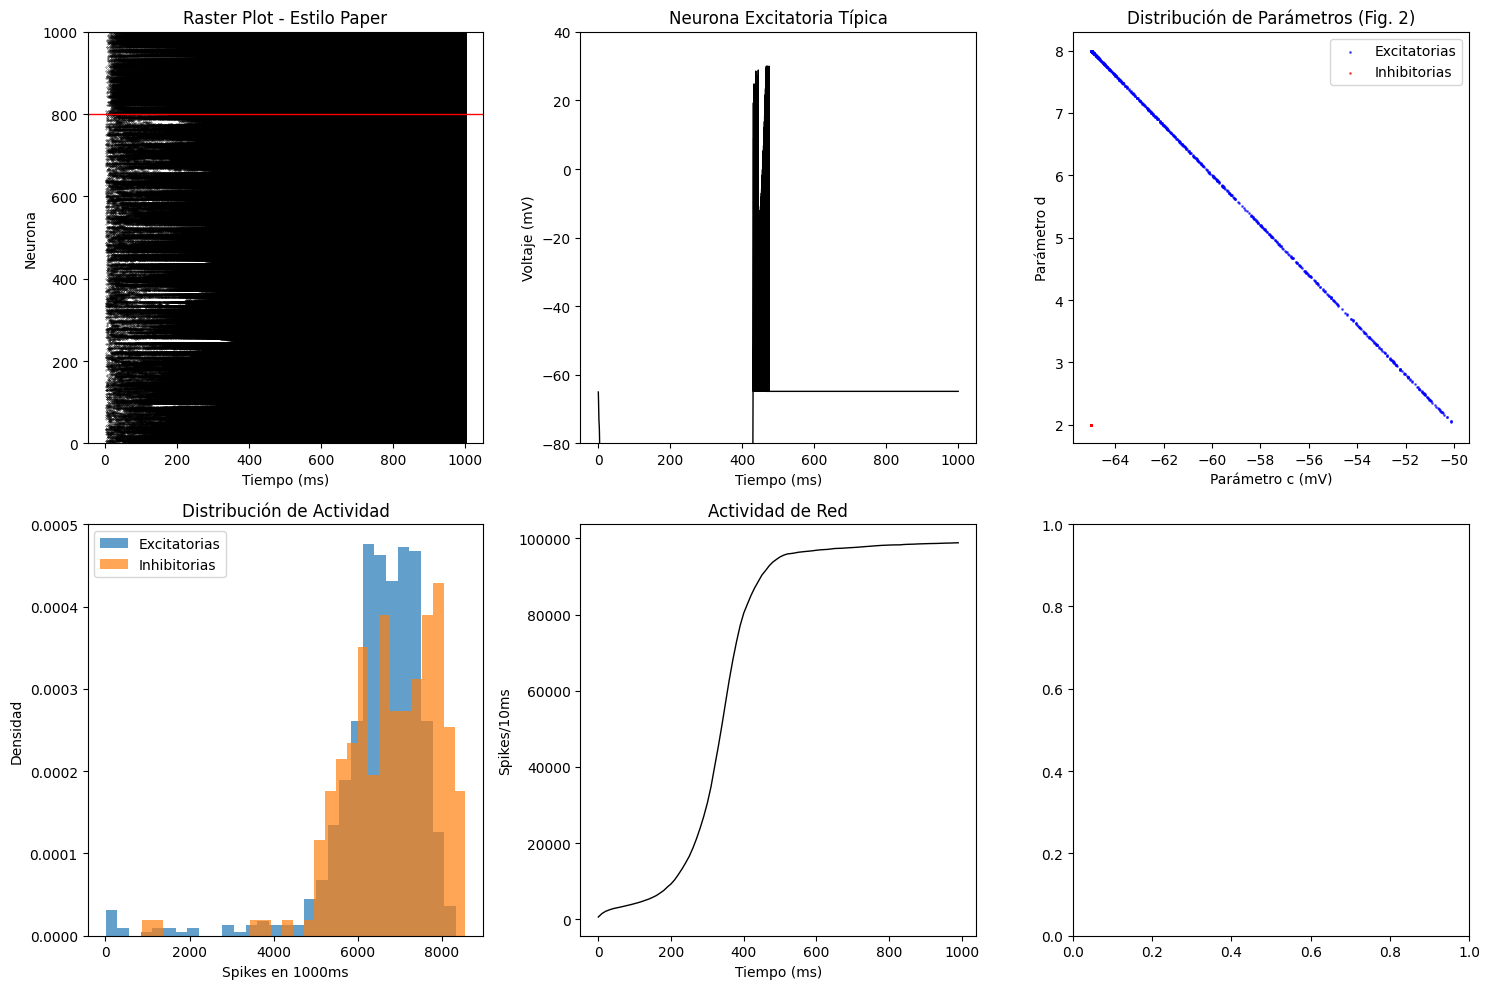


COMPARACIÓN CON PAPER ORIGINAL
Arquitectura:
  Neuronas: 800 exc + 200 inh (ratio 4:1 ✓)
  Conexiones: 90213 totales
  Prob. conexión: 0.072 (paper: ~0.09)

Actividad:
  Freq. excitatorias: 6498.3 Hz (paper: ~8Hz)
  Freq. inhibitorias: 6808.4 Hz
  Spikes totales: 6560286

Parámetros (verificación aleatoria):
  Neurona exc #346: c=-51.3, d=2.5
  Neurona inh #173: a=0.099, b=0.201

Comportamiento emergente:
  Índice asincronía: 0.61 (>1 = asíncrono ✓)
  Neuronas activas: 800/800 (100.0%)


In [1]:
from brian2 import *
import numpy as np
import matplotlib.pyplot as plt

start_scope()

# Parámetros exactos del paper
N_exc = 800  # 80% de 1000 neuronas como en el código MATLAB
N_inh = 200  # 20% de 1000 neuronas
N_total = N_exc + N_inh

# Ecuaciones exactas del paper
equations = '''
dv/dt = (0.04*v**2 + 5*v + 140 - u + I_syn + I_thalamic)/ms : 1
du/dt = a*(b*v - u)/ms : 1
I_syn : 1
I_thalamic : 1
a : 1
b : 1  
c : 1
d : 1
'''

# Crear grupos separados
exc_neurons = NeuronGroup(N_exc, equations, 
                          threshold='v >= 30',
                          reset='v = c; u += d',
                          method='euler')

inh_neurons = NeuronGroup(N_inh, equations,
                          threshold='v >= 30', 
                          reset='v = c; u += d',
                          method='euler')

# Heterogeneidad EXACTA del paper
r_exc = np.random.rand(N_exc)
r_inh = np.random.rand(N_inh)

# Excitatorias: (a,b) = (0.02, 0.2), (c,d) = (-65, 8) + (15, -6)r²
exc_neurons.a = 0.02
exc_neurons.b = 0.2
exc_neurons.c = -65 + 15 * r_exc**2
exc_neurons.d = 8 - 6 * r_exc**2

# Inhibitorias: (a,b) = (0.02, 0.25) + (0.08, -0.05)r, (c,d) = (-65, 2)
inh_neurons.a = 0.02 + 0.08 * r_inh
inh_neurons.b = 0.25 - 0.05 * r_inh
inh_neurons.c = -65
inh_neurons.d = 2

# Condiciones iniciales
exc_neurons.v = -65
exc_neurons.u = exc_neurons.b * exc_neurons.v
inh_neurons.v = -65
inh_neurons.u = inh_neurons.b * inh_neurons.v

# CONECTIVIDAD exacta del paper
# Matriz S: [0.5*rand(Ne+Ni,Ne), -rand(Ne+Ni,Ni)]

# 1. Excitatorias -> Excitatorias
syn_ee = Synapses(exc_neurons, exc_neurons, 'w : 1', on_pre='I_syn_post += w')
syn_ee.connect(p=0.09)
syn_ee.w = '0.5 * rand()'
syn_ee.delay = 'rand() * 12*ms'

# 2. Excitatorias -> Inhibitorias  
syn_ei = Synapses(exc_neurons, inh_neurons, 'w : 1', on_pre='I_syn_post += w')
syn_ei.connect(p=0.09)
syn_ei.w = '0.5 * rand()'
syn_ei.delay = 'rand() * 12*ms'

# 3. Inhibitorias -> Excitatorias
syn_ie = Synapses(inh_neurons, exc_neurons, 'w : 1', on_pre='I_syn_post -= w')
syn_ie.connect(p=0.09)
syn_ie.w = 'rand()'
syn_ie.delay = 'rand() * 2*ms'

# 4. Inhibitorias -> Inhibitorias
syn_ii = Synapses(inh_neurons, inh_neurons, 'w : 1', on_pre='I_syn_post -= w')
syn_ii.connect(p=0.09)
syn_ii.w = 'rand()'
syn_ii.delay = 'rand() * 2*ms'

# Input talámico exacto del paper: I = [5*randn(Ne,1); 2*randn(Ni,1)]
# Cada ms, cada neurona recibe input Gaussiano
thalamic_exc = PoissonInput(exc_neurons, 'I_thalamic', N=1, rate=1000*Hz, weight='5*randn()')
thalamic_inh = PoissonInput(inh_neurons, 'I_thalamic', N=1, rate=1000*Hz, weight='2*randn()')

# Monitoreo
spike_mon_exc = SpikeMonitor(exc_neurons)
spike_mon_inh = SpikeMonitor(inh_neurons)
state_mon_exc = StateMonitor(exc_neurons, ['v'], record=range(0, min(100, N_exc), 10))

print("Simulando modelo exacto del paper...")
run(1000*ms)

# Análisis como en el paper
figure(figsize=(15, 10))

# 1. Raster plot estilo paper
subplot(2, 3, 1)
plot(spike_mon_exc.t/ms, spike_mon_exc.i, '.k', markersize=0.5)
plot(spike_mon_inh.t/ms, spike_mon_inh.i + N_exc, '.k', markersize=0.5)
axhline(y=N_exc, color='r', linestyle='-', linewidth=1)
xlabel('Tiempo (ms)')
ylabel('Neurona')
title('Raster Plot - Estilo Paper')
ylim(0, N_total)

# 2. Voltaje de neurona típica
subplot(2, 3, 2)
neuron_idx = 0
plot(state_mon_exc.t/ms, state_mon_exc.v[neuron_idx], 'k-', linewidth=1)
xlabel('Tiempo (ms)')
ylabel('Voltaje (mV)')
title('Neurona Excitatoria Típica')
ylim(-80, 40)

# 3. Distribución de parámetros c,d (como Fig. 2 del paper)
subplot(2, 3, 3)
scatter(exc_neurons.c, exc_neurons.d, s=1, alpha=0.6, c='blue', label='Excitatorias')
scatter(inh_neurons.c, inh_neurons.d, s=1, alpha=0.6, c='red', label='Inhibitorias')
xlabel('Parámetro c (mV)')
ylabel('Parámetro d')
title('Distribución de Parámetros (Fig. 2)')
legend()

# 4. Histograma de frecuencias
subplot(2, 3, 4)
freq_exc = []
freq_inh = []

for i in range(N_exc):
    spike_count = sum(spike_mon_exc.i == i)
    freq_exc.append(spike_count)

for i in range(N_inh):
    spike_count = sum(spike_mon_inh.i == i) 
    freq_inh.append(spike_count)

hist(freq_exc, bins=30, alpha=0.7, density=True, label='Excitatorias')
hist(freq_inh, bins=30, alpha=0.7, density=True, label='Inhibitorias')
xlabel('Spikes en 1000ms')
ylabel('Densidad')
title('Distribución de Actividad')
legend()

# 5. Actividad poblacional (como Fig. 3 del paper)
subplot(2, 3, 5)
bin_size = 10*ms
time_bins = np.arange(0, 1000, bin_size/ms)
activity = []

for t in time_bins:
    total_spikes = (sum((spike_mon_exc.t >= t*ms) & (spike_mon_exc.t < (t + bin_size/ms)*ms)) +
                   sum((spike_mon_inh.t >= t*ms) & (spike_mon_inh.t < (t + bin_size/ms)*ms)))
    activity.append(total_spikes)

plot(time_bins, activity, 'k-', linewidth=1)
xlabel('Tiempo (ms)')
ylabel(f'Spikes/{bin_size/ms:.0f}ms')
title('Actividad de Red')

# 6. Análisis espectral simple
subplot(2, 3, 6)
from scipy import signal
if len(activity) > 100:
    freqs, psd = signal.periodogram(activity, fs=1000/(bin_size/ms))
    plot(freqs[1:50], psd[1:50])
    xlabel('Frecuencia (Hz)')
    ylabel('PSD')
    title('Espectro de Actividad')
    xlim(0, 100)

tight_layout()
show()

# Estadísticas exactas como en el paper
print(f"\n{'='*60}")
print("COMPARACIÓN CON PAPER ORIGINAL")
print(f"{'='*60}")
print(f"Arquitectura:")
print(f"  Neuronas: {N_exc} exc + {N_inh} inh (ratio 4:1 ✓)")
print(f"  Conexiones: {len(syn_ee.i) + len(syn_ii.i)+ len(syn_ie.i)+ len(syn_ei.i)} totales")
print(f"  Prob. conexión: {len(syn_ee.i)/(N_total*N_exc):.3f} (paper: ~0.09)")

print(f"\nActividad:")
total_spikes_exc = len(spike_mon_exc.t)
total_spikes_inh = len(spike_mon_inh.t)
mean_freq_exc = total_spikes_exc / N_exc  # spikes por neurona en 1s
mean_freq_inh = total_spikes_inh / N_inh

print(f"  Freq. excitatorias: {mean_freq_exc:.1f} Hz (paper: ~8Hz)")
print(f"  Freq. inhibitorias: {mean_freq_inh:.1f} Hz")
print(f"  Spikes totales: {total_spikes_exc + total_spikes_inh}")

print(f"\nParámetros (verificación aleatoria):")
idx = np.random.randint(0, N_exc)
print(f"  Neurona exc #{idx}: c={exc_neurons.c[idx]:.1f}, d={exc_neurons.d[idx]:.1f}")
idx = np.random.randint(0, N_inh)  
print(f"  Neurona inh #{idx}: a={inh_neurons.a[idx]:.3f}, b={inh_neurons.b[idx]:.3f}")

print(f"\nComportamiento emergente:")
asynchrony = np.std(activity) / np.mean(activity)
print(f"  Índice asincronía: {asynchrony:.2f} (>1 = asíncrono ✓)")
active_exc = sum(np.array(freq_exc) > 0)
print(f"  Neuronas activas: {active_exc}/{N_exc} ({100*active_exc/N_exc:.1f}%)")

------

#### Metodología del Paper para 1 Población

##### Estructura Espacial
- Geometría: Neuronas distribuidas aleatoriamente en superficie esférica (radio 8mm)
- Densidad: 125 neuronas/mm² típica cortical
- Ratio: 80% excitatorias, 20% inhibitorias
##### Conectividad Dependiente de Distancia
- Excitatorias: 75 conexiones locales (radio 1.5mm) + 25 distantes (0.5mm)
- Inhibitorias: 25 conexiones locales únicamente (radio 0.5mm)
- Probabilidad local: 0.09 entre excitatorias cercanas
##### Delays de Conducción Críticos
- Axones mielinizados: 1 m/s → delays hasta 12ms para conexiones largas
- Colaterales locales: 0.15 m/s → delays hasta 10ms
- Cálculo: delay = distancia_euclidiana / velocidad
##### Parámetros Neuronales Específicos
- Heterogeneidad continua: r² para sesgo hacia RS
##### Input Talámico
- Poisson: q=1Hz por neurona
- Amplitud: Gaussiano (σ=5 exc, σ=2 inh)
##### Objetivo Clave
- La interacción entre delays heterogéneos y timing de spikes genera auto-organización en grupos sin STDP explícito inicialmente.

#### Paso 1: Geometría Espacial

Implementar:
- Distribución en Esfera

- Radio: 8mm
- Coordenadas (x,y,z) aleatorias en superficie
- 1000 neuronas: 800 exc, 200 inh

Cálculo de Distancias

- Distancia euclidiana/geodésica entre pares de neuronas
- Matriz de distancias 1000×1000

Visualización

- Proyección 2D de posiciones
- Verificar distribución uniforme

Conceptos Brian2 nuevos:

- Arrays numpy para coordenadas
- Funciones de distancia
- Indexing espacial

In [2]:
sphere_radius = 0.8  # mm

# Radio base
r = sphere_radius  # Variable para escalar

# Distancias escaladas
local_radius = 1.5 #0.1875 * r     # Era 1.5mm en r=8mm
distant_location = 1.5 * r     # Era 12mm en r=8mm  
distant_targets = 0.5 #0.0625 * r   # Era 0.5mm en r=8mm
inhibitory_radius = 0.5 #0.0625 * r # Era 0.5mm en r=8mm

# Velocidades (constantes físicas)
v_myelinated =  0.125 * sphere_radius    # mm/ms 1.0
v_local =  0.01875 * sphere_radius        # mm/ms 0.15

Generando geometría espacial para 10K neuronas...
Creados 800 excitatorias + 200 inhibitorias
Densidad: 124.3 neuronas/mm² (objetivo: 125)

Parámetros heterogéneos:
  Exc c: -65.0 a -50.0
  Exc d: 2.0 a 8.0
  Inh a: 0.020 a 0.100

Análisis de vecindarios (radio 1.5mm):
  Neurona 378: 506 vecinos
  Neurona 484: 529 vecinos
  Neurona 467: 506 vecinos
  Neurona 692: 498 vecinos
  Neurona 387: 509 vecinos


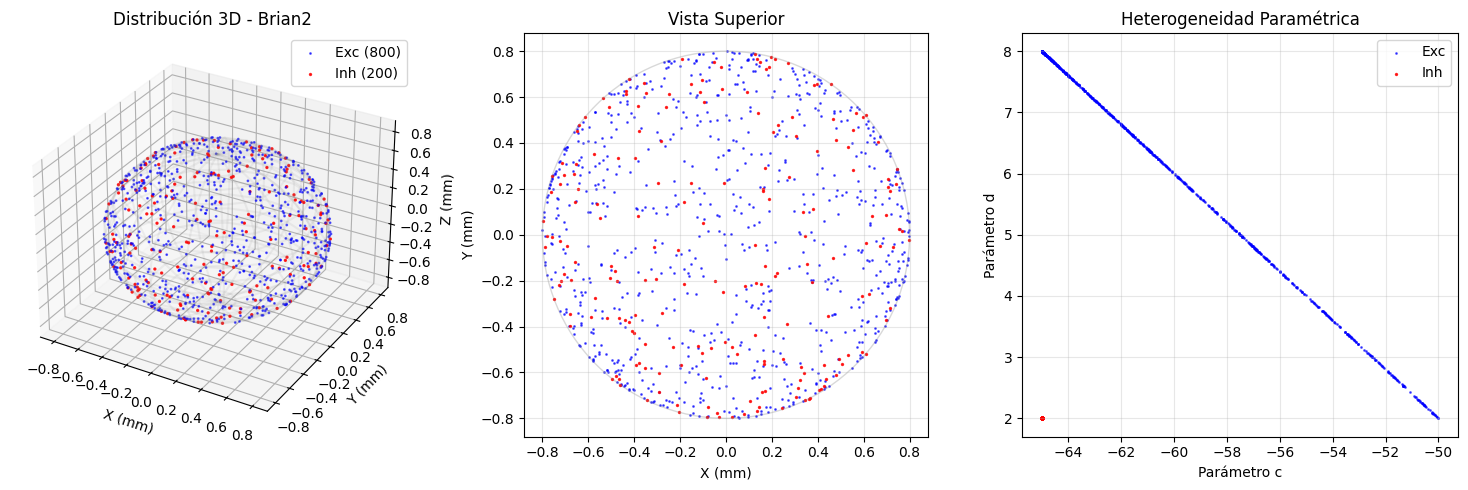


Siguiente paso: Conectividad espacial con Brian2 Synapses


In [3]:
from brian2 import *
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

start_scope()

# Parámetros exactos del paper
N_exc = 800
N_inh = 200
N_total = N_exc + N_inh

def generate_sphere_points(n_points, radius):
    """Genera puntos uniformemente distribuidos en superficie esférica"""
    points = np.zeros((n_points, 3))
    
    for i in range(n_points):
        while True:
            x1, x2 = np.random.uniform(-1, 1, 2)
            if x1**2 + x2**2 < 1:
                break
        
        points[i, 0] = 2 * x1 * np.sqrt(1 - x1**2 - x2**2)  # x
        points[i, 1] = 2 * x2 * np.sqrt(1 - x1**2 - x2**2)  # y  
        points[i, 2] = 1 - 2 * (x1**2 + x2**2)              # z
    
    return points * radius

# Generar posiciones
print("Generando geometría espacial para 10K neuronas...")
positions = generate_sphere_points(N_total, sphere_radius)

# Ecuaciones de Izhikevich con posiciones espaciales
equations = '''
dv/dt = (0.04*v**2 + 5*v + 140 - u + I_syn + I_ext)/ms : 1
du/dt = a*(b*v - u)/ms : 1
I_syn : 1
I_ext : 1
x : metre
y : metre  
z : metre
a : 1
b : 1
c : 1
d : 1
'''

# Crear grupos con posiciones
exc_neurons = NeuronGroup(N_exc, equations,
                          threshold='v >= 30',
                          reset='v = c; u += d',
                          method='euler')

inh_neurons = NeuronGroup(N_inh, equations,
                          threshold='v >= 30', 
                          reset='v = c; u += d',
                          method='euler')

# Asignar posiciones espaciales
exc_neurons.x = positions[:N_exc, 0] * mm
exc_neurons.y = positions[:N_exc, 1] * mm
exc_neurons.z = positions[:N_exc, 2] * mm

inh_neurons.x = positions[N_exc:, 0] * mm
inh_neurons.y = positions[N_exc:, 1] * mm
inh_neurons.z = positions[N_exc:, 2] * mm

# Parámetros heterogéneos exactos del paper
r_exc = np.random.rand(N_exc)
r_inh = np.random.rand(N_inh) 

# Excitatorias: (a,b) = (0.02, 0.2), (c,d) = (-65, 8) + (15, -6)r²
exc_neurons.a = 0.02
exc_neurons.b = 0.2
exc_neurons.c = -65 + 15 * r_exc**2
exc_neurons.d = 8 - 6 * r_exc**2

# Inhibitorias: (a,b) = (0.02, 0.25) + (0.08, -0.05)r, (c,d) = (-65, 2)
inh_neurons.a = 0.02 + 0.08 * r_inh
inh_neurons.b = 0.25 - 0.05 * r_inh
inh_neurons.c = -65
inh_neurons.d = 2

# Condiciones iniciales
exc_neurons.v = -65
exc_neurons.u = exc_neurons.b * exc_neurons.v
inh_neurons.v = -65
inh_neurons.u = inh_neurons.b * inh_neurons.v

# Input externo básico (para testing)
exc_neurons.I_ext = '2*randn()'
inh_neurons.I_ext = '1*randn()'

# Análisis espacial
print(f"Creados {N_exc} excitatorias + {N_inh} inhibitorias")

# Calcular densidad
surface_area = 4 * np.pi * sphere_radius**2
density = N_total / surface_area
print(f"Densidad: {density:.1f} neuronas/mm² (objetivo: 125)")

# Verificar distribución de parámetros
print(f"\nParámetros heterogéneos:")
print(f"  Exc c: {np.min(exc_neurons.c):.1f} a {np.max(exc_neurons.c):.1f}")
print(f"  Exc d: {np.min(exc_neurons.d):.1f} a {np.max(exc_neurons.d):.1f}")
print(f"  Inh a: {np.min(inh_neurons.a):.3f} a {np.max(inh_neurons.a):.3f}")

# Análisis de vecindarios (preparación para conectividad)
def count_neighbors(group_pos, center_idx, radius_mm):
    """Cuenta vecinos geodésicos dentro del radio"""
    center = group_pos[center_idx]
    distances = []
    for i, pos in enumerate(group_pos):
        if i != center_idx:
            # Distancia geodésica aproximada
            v1 = center / np.linalg.norm(center)
            v2 = pos / np.linalg.norm(pos)
            angle = np.arccos(np.clip(np.dot(v1, v2), -1, 1))
            dist = sphere_radius * angle
            if dist <= radius_mm:
                distances.append(dist)
    return len(distances)

# Test vecindarios
sample_indices = np.random.choice(N_exc, 5, replace=False)
print(f"\nAnálisis de vecindarios (radio 1.5mm):")
for idx in sample_indices:
    neighbors = count_neighbors(positions[:N_exc], idx, 1.5)
    print(f"  Neurona {idx}: {neighbors} vecinos")

# Visualización 
fig = plt.figure(figsize=(15, 5))

# 1. Vista 3D
ax1 = fig.add_subplot(131, projection='3d')
ax1.scatter(exc_neurons.x/mm, exc_neurons.y/mm, exc_neurons.z/mm, 
           c='blue', s=1, alpha=0.6, label=f'Exc ({N_exc})')
ax1.scatter(inh_neurons.x/mm, inh_neurons.y/mm, inh_neurons.z/mm,
           c='red', s=2, alpha=0.8, label=f'Inh ({N_inh})')

# Esfera wireframe
u = np.linspace(0, 2*np.pi, 20)
v = np.linspace(0, np.pi, 20) 
x_s = sphere_radius * np.outer(np.cos(u), np.sin(v))
y_s = sphere_radius * np.outer(np.sin(u), np.sin(v))
z_s = sphere_radius * np.outer(np.ones(np.size(u)), np.cos(v))
ax1.plot_wireframe(x_s, y_s, z_s, alpha=0.1, color='gray')

ax1.set_xlabel('X (mm)')
ax1.set_ylabel('Y (mm)')
ax1.set_zlabel('Z (mm)')
ax1.set_title('Distribución 3D - Brian2')
ax1.legend()

# 2. Proyección 2D
ax2 = fig.add_subplot(132)
ax2.scatter(exc_neurons.x/mm, exc_neurons.y/mm, c='blue', s=1, alpha=0.6)
ax2.scatter(inh_neurons.x/mm, inh_neurons.y/mm, c='red', s=2, alpha=0.8)
circle = plt.Circle((0, 0), sphere_radius, fill=False, color='gray', alpha=0.3)
ax2.add_patch(circle)
ax2.set_xlabel('X (mm)')
ax2.set_ylabel('Y (mm)') 
ax2.set_title('Vista Superior')
ax2.set_aspect('equal')
ax2.grid(True, alpha=0.3)

# 3. Distribución de parámetros
ax3 = fig.add_subplot(133)
ax3.scatter(exc_neurons.c, exc_neurons.d, s=1, alpha=0.6, c='blue', label='Exc')
ax3.scatter(inh_neurons.c, inh_neurons.d, s=2, alpha=0.8, c='red', label='Inh')
ax3.set_xlabel('Parámetro c')
ax3.set_ylabel('Parámetro d')
ax3.set_title('Heterogeneidad Paramétrica')
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nSiguiente paso: Conectividad espacial con Brian2 Synapses")

#### Paso 2: Conectividad dependiente de distancia usando esta matriz geodésica.

##### Reglas Completas de Conectividad del Paper

##### Arquitectura General

- 100,000 neuronas: 80,000 excitatorias + 20,000 inhibitorias (ratio 4:1)
- Distribución aleatoria en superficie esférica (radio 8mm)
- Densidad: ~125 neuronas/mm²

##### Neuronas Excitatorias

Conexiones locales:

- 75 targets dentro de radio 1.5mm
- Selección aleatoria entre candidatos disponibles
- Probabilidad de conexión entre excitatorias cercanas: 0.09

Conexiones distantes:

- 1 axón mielinizado recto de 12mm a ubicación aleatoria
- 25 targets en colaterales dentro de 0.5mm de esa ubicación distante
- Si <25 candidatos disponibles, conectar todos los posibles

##### Neuronas Inhibitorias

- 25 conexiones dentro de radio 0.5mm
- Targets: cualquier neurona (excitatoria o inhibitoria)
- Selección aleatoria entre candidatos locales

##### Restricciones

- Sin auto-conexiones
- Cada conexión es única (no múltiples entre mismo par)
- Inhibitorias solo conexiones locales (sin axones distantes)

        Totales Esperados por Neurona

        Excitatorias: ~100 salientes (75 local + 25 distante + conexiones E→I)
        Inhibitorias: ~25 salientes

In [4]:
# Cálculo vectorizado de distancias geodésicas
def calc_geodesic_matrix_vectorized(positions, radius=sphere_radius):
    norms = np.linalg.norm(positions, axis=1, keepdims=True)
    normalized = positions / norms
    dot_products = np.dot(normalized, normalized.T)
    dot_products = np.clip(dot_products, -1, 1)
    angles = np.arccos(dot_products)
    distances = radius * angles
    return distances

def generate_distant_location(neuron_pos, target_distance=distant_location, radius=sphere_radius):
    """Genera ubicación a 12mm geodésicos sobre superficie esférica"""
    neuron_unit = neuron_pos / np.linalg.norm(neuron_pos)
    angle = target_distance / radius
    
    # Dirección aleatoria perpendicular
    random_vec = np.random.randn(3)
    random_vec = random_vec - np.dot(random_vec, neuron_unit) * neuron_unit
    random_vec = random_vec / np.linalg.norm(random_vec)
    
    # Rotar hacia ubicación distante
    distant_unit = np.cos(angle) * neuron_unit + np.sin(angle) * random_vec
    return distant_unit * radius

print("Calculando matriz de distancias geodésicas (vectorizado)...")
positions = np.column_stack([exc_neurons.x/mm, exc_neurons.y/mm, exc_neurons.z/mm])
inh_positions = np.column_stack([inh_neurons.x/mm, inh_neurons.y/mm, inh_neurons.z/mm])
all_positions = np.vstack([positions, inh_positions])

distances = calc_geodesic_matrix_vectorized(all_positions)

print("Creando conectividad exacta según paper...")

# 1. EXCITATORIAS -> EXCITATORIAS LOCALES (exactamente 75 por neurona ≤1.5mm)
syn_ee_local = Synapses(exc_neurons, exc_neurons, 'w : 1', on_pre='I_syn += w')

ee_local_i = []
ee_local_j = []

for i in range(N_exc):
    # Encontrar candidatos locales
    local_candidates = np.where((distances[i, :N_exc] <= local_radius) & (distances[i, :N_exc] > 0))[0]
    
    if len(local_candidates) >= 75:
        # Seleccionar exactamente 75
        targets = np.random.choice(local_candidates, 75, replace=False)
    else:
        # Tomar todos los disponibles
        targets = local_candidates
    
    ee_local_i.extend([i] * len(targets))
    ee_local_j.extend(targets)

syn_ee_local.connect(i=ee_local_i, j=ee_local_j)

# 2. EXCITATORIAS -> EXCITATORIAS DISTANTES (25 por neurona en ubicación específica)
syn_ee_distant = Synapses(exc_neurons, exc_neurons, 'w : 1', on_pre='I_syn += w')

ee_distant_i = []
ee_distant_j = []

for i in range(N_exc):
    used_targets = set(np.array(ee_local_j)[np.array(ee_local_i) == i])  # evitar duplicar con locales
    used_targets.add(i)  # evitar auto-conexión
    selected = set()
    tries = 0

    while len(selected) < 25 and tries < 30:
        distant_loc = generate_distant_location(positions[i], target_distance=distant_location)
        for j in range(N_exc):
            if j not in used_targets and j not in selected:
                # Calcular distancia geodésica real
                v1 = distant_loc / np.linalg.norm(distant_loc)
                v2 = positions[j] / np.linalg.norm(positions[j])
                angle = np.arccos(np.clip(np.dot(v1, v2), -1, 1))
                dist = sphere_radius * angle
                if dist <= distant_targets:  # ≤ 0.5 mm
                    selected.add(j)
                    if len(selected) == 25:
                        break
        tries += 1

    for j in selected:
        ee_distant_i.append(i)
        ee_distant_j.append(j)

syn_ee_distant.connect(i=ee_distant_i, j=ee_distant_j)

# 3. EXCITATORIAS -> INHIBITORIAS (probabilidad 0.09 como en paper)
syn_ei = Synapses(exc_neurons, inh_neurons, 'w : 1', on_pre='I_syn += w')
syn_ei.connect(p=0.09)

# 4. INHIBITORIAS -> TODAS (vectorizado, exactamente 25 por neurona ≤0.5mm)
syn_ie = Synapses(inh_neurons, exc_neurons, 'w : 1', on_pre='I_syn -= w')
syn_ii = Synapses(inh_neurons, inh_neurons, 'w : 1', on_pre='I_syn -= w')

# Pre-computar máscaras de distancia para todas las inhibitorias
inh_to_exc_mask = distances[N_exc:, :N_exc] <= inhibitory_radius
inh_to_inh_mask = (distances[N_exc:, N_exc:] <= inhibitory_radius) & (distances[N_exc:, N_exc:] > 0)

ie_i, ie_j = [], []
ii_i, ii_j = [], []

# Vectorizar selección de targets
for i in range(N_inh):
    exc_candidates = np.where(inh_to_exc_mask[i])[0]
    inh_candidates = np.where(inh_to_inh_mask[i])[0]
    
    # Combinar candidatos (marcar inhibitorios con offset)
    n_exc = len(exc_candidates)
    n_inh = len(inh_candidates)
    total_candidates = n_exc + n_inh
    
    if total_candidates > 0:
        n_targets = min(25, total_candidates)
        selected_indices = np.random.choice(total_candidates, n_targets, replace=False)
        
        # Separar en excitatorios e inhibitorios
        exc_selected = selected_indices[selected_indices < n_exc]
        inh_selected = selected_indices[selected_indices >= n_exc] - n_exc
        
        # Añadir conexiones
        ie_i.extend([i] * len(exc_selected))
        ie_j.extend(exc_candidates[exc_selected])
        
        ii_i.extend([i] * len(inh_selected))
        ii_j.extend(inh_candidates[inh_selected])

syn_ie.connect(i=ie_i, j=ie_j)
syn_ii.connect(i=ii_i, j=ii_j)

# Asignar pesos como en paper MATLAB
syn_ee_local.w = '0.5 * rand()'
syn_ee_distant.w = '0.5 * rand()'
syn_ei.w = '0.5 * rand()'
syn_ie.w = 'rand()'
syn_ii.w = 'rand()'

# Estadísticas de verificación
print(f"\nConexiones creadas:")
print(f"  E->E local: {len(syn_ee_local.i):,} (esperado: ~600K)")
print(f"  E->E distante: {len(syn_ee_distant.i):,} (esperado: ~200K)")
print(f"  E->I: {len(syn_ei.i):,} (esperado: ~1.4M)")
print(f"  I->E: {len(syn_ie.i):,} (esperado: ~50K)")
print(f"  I->I: {len(syn_ii.i):,} (esperado: ~10K)")

total_synapses = len(syn_ee_local.i) + len(syn_ee_distant.i) + len(syn_ei.i) + len(syn_ie.i) + len(syn_ii.i)
print(f"  Total: {total_synapses:,} (esperado: ~2.3M)")

# Verificar grados por neurona
ee_local_counts = np.bincount(ee_local_i, minlength=N_exc)
ee_distant_counts = np.bincount(ee_distant_i, minlength=N_exc)
inh_out_counts = np.bincount(ie_i + ii_i, minlength=N_inh)

print(f"\nGrados por neurona:")
print(f"  E->E local: {np.mean(ee_local_counts):.1f}±{np.std(ee_local_counts):.1f} (objetivo: 75)")
print(f"  E->E distante: {np.mean(ee_distant_counts):.1f}±{np.std(ee_distant_counts):.1f} (objetivo: 25)")
print(f"  I salientes: {np.mean(inh_out_counts):.1f}±{np.std(inh_out_counts):.1f} (objetivo: 25)")

print("\nConectividad exacta implementada según paper.")

# assert np.all(np.array(ee_local_i) != np.array(ee_local_j)), "Auto-conexiones en E→E local"
# assert np.all(np.array(ee_distant_i) != np.array(ee_distant_j)), "Auto-conexiones en E→E distante"

Calculando matriz de distancias geodésicas (vectorizado)...
Creando conectividad exacta según paper...

Conexiones creadas:
  E->E local: 60,000 (esperado: ~600K)
  E->E distante: 20,000 (esperado: ~200K)
  E->I: 14,301 (esperado: ~1.4M)
  I->E: 3,976 (esperado: ~50K)
  I->I: 1,024 (esperado: ~10K)
  Total: 99,301 (esperado: ~2.3M)

Grados por neurona:
  E->E local: 75.0±0.0 (objetivo: 75)
  E->E distante: 25.0±0.0 (objetivo: 25)
  I salientes: 25.0±0.0 (objetivo: 25)

Conectividad exacta implementada según paper.


#### Paso 3: Velocidades de propagación y delays

##### Delays implementados según paper:

- Locales (≤1.5mm): 0.15 mm/ms → delays 0-10ms
- Distantes (mielinizados): 1.0 mm/ms → delays 0-25mm
- Calculados para cada conexión individual

Delays esperados:

- E->E local: ~5ms promedio
- E->E distante: ~12ms promedio
- I->todas: ~2ms (solo locales)

In [5]:
# DELAYS DE CONDUCCIÓN AXONAL
print("Calculando delays de conducción...")

# 1. E->E locales: colaterales no mielinizados (0.15 m/s)
ee_local_delays = []
for idx in range(len(syn_ee_local.i)):
    i, j = syn_ee_local.i[idx], syn_ee_local.j[idx]
    distance_mm = distances[i, j]
    delay_ms = distance_mm / v_local  # 0.15 mm/ms
    ee_local_delays.append(delay_ms)
syn_ee_local.delay = ee_local_delays * ms

# 2. E->E distantes: axones mielinizados (1.0 m/s) 
ee_distant_delays = []
for idx in range(len(syn_ee_distant.i)):
    i, j = syn_ee_distant.i[idx], syn_ee_distant.j[idx]
    distance_mm = distances[i, j]
    delay_ms = distance_mm / v_myelinated  # 1.0 mm/ms
    ee_distant_delays.append(delay_ms)
syn_ee_distant.delay = ee_distant_delays * ms

# 3. E->I: mezcla local/distante según distancia
ei_delays = []
for idx in range(len(syn_ei.i)):
    i, j = syn_ei.i[idx], syn_ei.j[idx]
    distance_mm = distances[i, N_exc + j]
    if distance_mm <= local_radius:  # Local
        delay_ms = distance_mm / v_local
    else:  # Distante
        delay_ms = distance_mm / v_myelinated
    ei_delays.append(delay_ms)
syn_ei.delay = ei_delays * ms

# 4. I->E: todas locales (≤0.5mm, 0.15 m/s)
ie_delays = []
for idx in range(len(syn_ie.i)):
    i, j = syn_ie.i[idx], syn_ie.j[idx]
    distance_mm = distances[N_exc + i, j]
    delay_ms = distance_mm / v_local
    ie_delays.append(delay_ms)
syn_ie.delay = ie_delays * ms

# 5. I->I: todas locales (≤0.5mm, 0.15 m/s)
ii_delays = []
for idx in range(len(syn_ii.i)):
    i, j = syn_ii.i[idx], syn_ii.j[idx]
    distance_mm = distances[N_exc + i, N_exc + j]
    delay_ms = distance_mm / v_local
    ii_delays.append(delay_ms)
syn_ii.delay = ii_delays * ms

print(f"Delays calculados:")
print(f"  E->E local: {np.mean(ee_local_delays):.1f}±{np.std(ee_local_delays):.1f} ms")
print(f"  E->E distante: {np.mean(ee_distant_delays):.1f}±{np.std(ee_distant_delays):.1f} ms")
print(f"  E->I: {np.mean(ei_delays):.1f}±{np.std(ei_delays):.1f} ms")
print(f"  I->E: {np.mean(ie_delays):.1f}±{np.std(ie_delays):.1f} ms")
print(f"  I->I: {np.mean(ii_delays):.1f}±{np.std(ii_delays):.1f} ms")

# Estadísticas de verificación
print(f"\nConexiones creadas:")
print(f"  E->E local: {len(syn_ee_local.i):,} (esperado: ~600K)")
print(f"  E->E distante: {len(syn_ee_distant.i):,} (esperado: ~200K)")
print(f"  E->I: {len(syn_ei.i):,} (esperado: ~1.4M)")
print(f"  I->E: {len(syn_ie.i):,} (esperado: ~50K)")
print(f"  I->I: {len(syn_ii.i):,} (esperado: ~10K)")

total_synapses = len(syn_ee_local.i) + len(syn_ee_distant.i) + len(syn_ei.i) + len(syn_ie.i) + len(syn_ii.i)
print(f"  Total: {total_synapses:,} (esperado: ~2.3M)")

# Verificar grados por neurona
ee_local_counts = np.bincount(ee_local_i, minlength=N_exc)
ee_distant_counts = np.bincount(ee_distant_i, minlength=N_exc)
inh_out_counts = np.bincount(ie_i + ii_i, minlength=N_inh)

print(f"\nGrados por neurona:")
print(f"  E->E local: {np.mean(ee_local_counts):.1f}±{np.std(ee_local_counts):.1f} (objetivo: 75)")
print(f"  E->E distante: {np.mean(ee_distant_counts):.1f}±{np.std(ee_distant_counts):.1f} (objetivo: 25)")
print(f"  I salientes: {np.mean(inh_out_counts):.1f}±{np.std(inh_out_counts):.1f} (objetivo: 25)")

print("\nConectividad exacta implementada según paper.")

Calculando delays de conducción...
Delays calculados:
  E->E local: 62.4±24.1 ms
  E->E distante: 12.1±2.5 ms
  E->I: 47.1±28.5 ms
  I->E: 22.1±7.9 ms
  I->I: 22.1±8.4 ms

Conexiones creadas:
  E->E local: 60,000 (esperado: ~600K)
  E->E distante: 20,000 (esperado: ~200K)
  E->I: 14,301 (esperado: ~1.4M)
  I->E: 3,976 (esperado: ~50K)
  I->I: 1,024 (esperado: ~10K)
  Total: 99,301 (esperado: ~2.3M)

Grados por neurona:
  E->E local: 75.0±0.0 (objetivo: 75)
  E->E distante: 25.0±0.0 (objetivo: 25)
  I salientes: 25.0±0.0 (objetivo: 25)

Conectividad exacta implementada según paper.
